# 申万行业轮动四象限模型复现

申万行业轮动四象限模型主要观点：

1. 市场上的投资者会随着政策、经济环境等因素不断改变自己的投资方向，从而改变资金在不同行业之间的配置，行业的涨跌轮动便产生了；
2. 通过对风格相互对立的两两行业对，如成长型和价值型、大盘股和小盘股构建相对强弱指标，找到在时间序列上每一个给定时点的风格相对强度，得出市场风格的情况；
3. 寻找两两风格对之间的轮动规律，根据轮动规律推断当前市场所处的风格区间以及下一个状态的可能风格

*本次复现实验数据驱动由akshare实现，暂时仅采用了大小盘的相对强度曲线进行。*

*TODO: 1. 还需要对给定所处象限的日期的下一个交易日、下一个交易周、下一个交易月等不同时间周期后所处的象限位置进行统计；2. 还需要尝试对不同的风格对进行实验；3. 生成复现脚本，可以通过输入特定参数得出四象限模型图*

## 复现流程

首先，我们引入程序运行的必要工具包

注意一下，这里使用的font是必须的，已经在assets文件夹给出。**值得一提的是，这里的font的确是一个很好的在matplotlib中设定字体的方式，不需要特意安装字体，只要把字体文件放到文件夹里，再看看字体的PostScript Name就可以了**

In [1]:
import pandas as pd
import numpy as np
import akshare as ak
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

font = fontManager.addfont("../assets/font/xingshu.ttf")
plt.rcParams['font.sans-serif'] = "FZXuJingLeiXingShuS"

通过akshare获取数据，因为研究对象为大小盘的相对强弱指数，所以这里我们选择的是大小盘的指数，指数的数据源为新浪，代码为`SH000045(上证小盘)`和`SH000043(超大盘)`，数据参考在[这里](https://www.akshare.xyz/data/index/index.html)。

获取数据后，很自然的将date作为索引，同时date转为时间类型以便后面进行索引

In [2]:
small = ak.stock_zh_index_daily("sh000045").set_index("date")
big = ak.stock_zh_index_daily("sh000043").set_index("date")
small.index = pd.to_datetime(small.index)
big.index = pd.to_datetime(big.index)

将收盘价从数据中提取出来，并计算其收益率

In [3]:
small_ret = small.close / small.close.shift(1) - 1
big_ret = big.close / big.close.shift(1) - 1

将第一条数据（没有收益率）剔除后，并将收益率转换为可以直接相乘的的结果

In [4]:
small_ret = small_ret.replace(np.nan, 0) + 1
big_ret = big_ret.replace(np.nan, 0) + 1

计算大小盘指数的累计收益率

In [5]:
small_retcum = small_ret.cumprod()
big_retcum = big_ret.cumprod()

构建大小盘相对强弱指数，根据申万行业轮动强弱指数的定义，价格的相对强弱计算方式为

$$
RWS = \frac{log(cumret(Ind_A))}{log(cumret(Ind_B))}
$$

其中cumret表示累计收益率，Ind表示行业

计算完成后，为了对结果进行平滑化，取了十日的滑动平均值

<AxesSubplot:xlabel='date'>

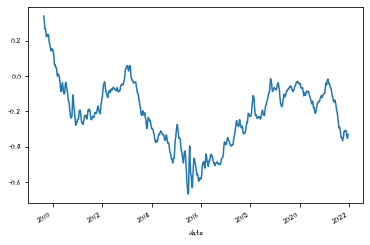

In [6]:
rws = np.log(big_retcum / small_retcum)
rwsma = rws.rolling(10).mean().dropna()
rwsma.plot()

在理想情况下，行业轮动存在一个周期意味着行业相对强弱指数是有一定的上涨和下跌波动周期的。理想的波动曲线是如同正弦函数一般起伏，因此可以将行业周期划分为四个阶段：

1. 加速上升，在这个阶段，行业A（大盘股）相对小盘股更为强势，同时这种趋势才刚刚开始，动量充足，有加速上升之意
2. 减速上升，在这个阶段，强势行业逐渐被高估，上升势力放缓，速度降低
3. 加速下降，在这个阶段，原先的弱势行业（小盘股）逐渐崛起，大盘股相对小盘股收益加速降低
4. 减速下降，在这个阶段，原先的弱势行业逐渐被高估，相对收益下跌放缓

这四个阶段对应着相对强弱曲线的一阶导数和二阶导数的关系为：

1. 阶段一：$f'(x) > 0; f''(x) > 0$
2. 阶段二：$f'(x) > 0; f''(x) < 0$
3. 阶段三：$f'(x) < 0; f''(x) < 0$
4. 阶段四：$f'(x) < 0; f''(x) > 0$

但是目前的问题是，如何对一个不连续的函数求导，这里研报中采用给定滚动时间窗口内数据进行线性拟合的方法。（还有一个自己想出来的办法是直接用给定时间窗内的收益率作为导数）

In [9]:
def _reg(data):
    data = data.copy()
    x = np.arange(data.shape[0])
    x = sm.add_constant(x)
    y = data.values
    model = sm.OLS(y, x)
    result = model.fit()
    # return result.params[0], result.params[1]
    return result.params[1]

def _ret(data):
    x2 = len(data)
    x1 = 0
    y2 = data.iloc[-1]
    y1 = data.iloc[0]
    inter = (x2 * y1 - x1 * y2) / (x2 - x1) 
    coef = (y2 - y1) / (x2 - x1)
    # return inter, coef
    return coef

下面的代码是用来做测试的，要想跑通必须把上面函数的return分别切换为第9行和第18行

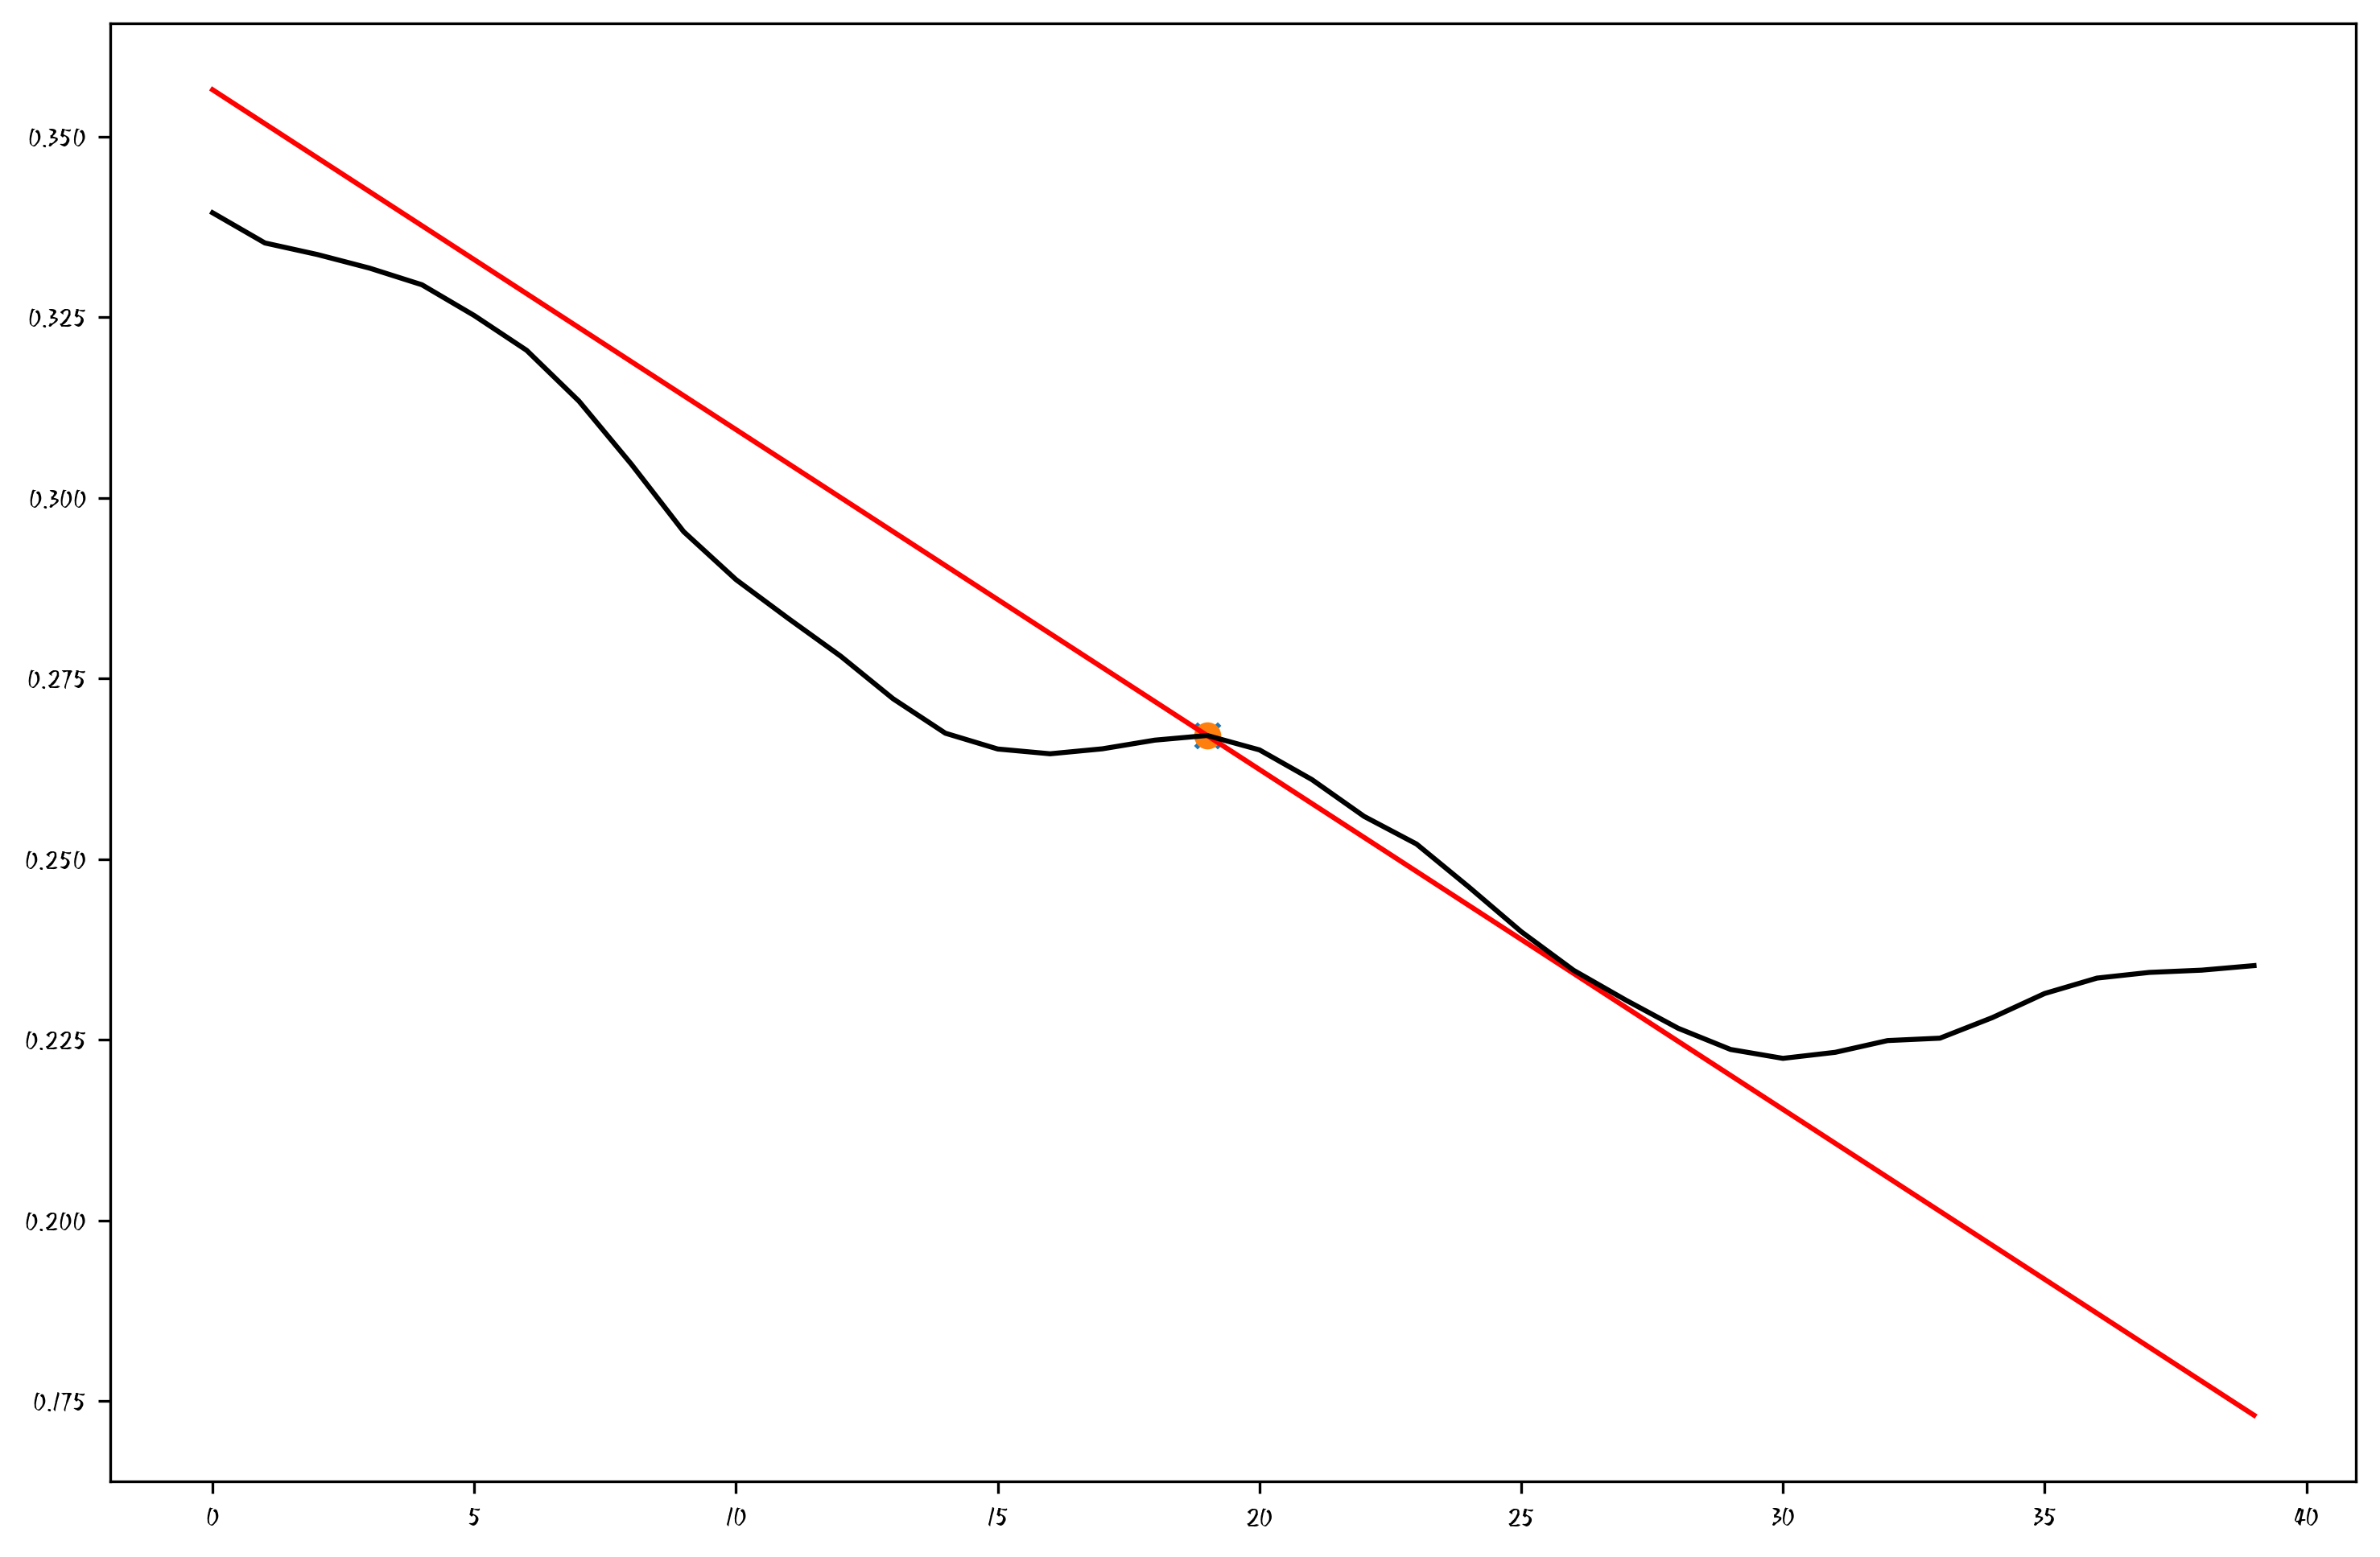

In [8]:
# 可以用下面的代码测测看，以_reg函数计算结果作为导数的效果
start_day = 0
n_days = 20
end_day = start_day + n_days
draw_end = start_day + n_days * 2
intersect, coef = _reg(rwsma.iloc[start_day:end_day])
# intersect, coef = _ret(rwsma.iloc[start_day + n_days - 2:start_day + n_days])
x = np.arange(40)
y = intersect + coef * x
diff = rwsma.iloc[start_day + n_days - 1] - y[n_days - 1]
y = y + diff
_, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
ax.plot(x, y, color="red")
ax.plot(np.arange(draw_end - start_day), rwsma.iloc[start_day:draw_end], color="black")
ax.scatter(n_days - 1, rwsma.iloc[start_day + n_days - 1], s=50, marker='x')
ax.scatter(n_days - 1, y[n_days - 1], s=50, marker='o')

接下来的任务就是计算一阶“导数”和二阶“导数”，这里的时间窗口我们采用的是20天，别问为啥，问就是试出来的效果相对好一些的天数:)

In [10]:
derivative1 = rwsma.rolling(20).apply(_reg)
derivative2 = derivative1.rolling(20).apply(_reg)

# derivative1 = rwsma.rolling(2).apply(_ret)
# derivative2 = derivative1.rolling(2).apply(_ret)

derivative1 = derivative1.dropna()
derivative2 = derivative2.dropna()

接下来跑一下结果可视化，三个子图绘制的分别是原强弱指数曲线和一阶“导数”、一阶“导数”和二阶“导数”以及二阶“导数”和原强弱指数曲线

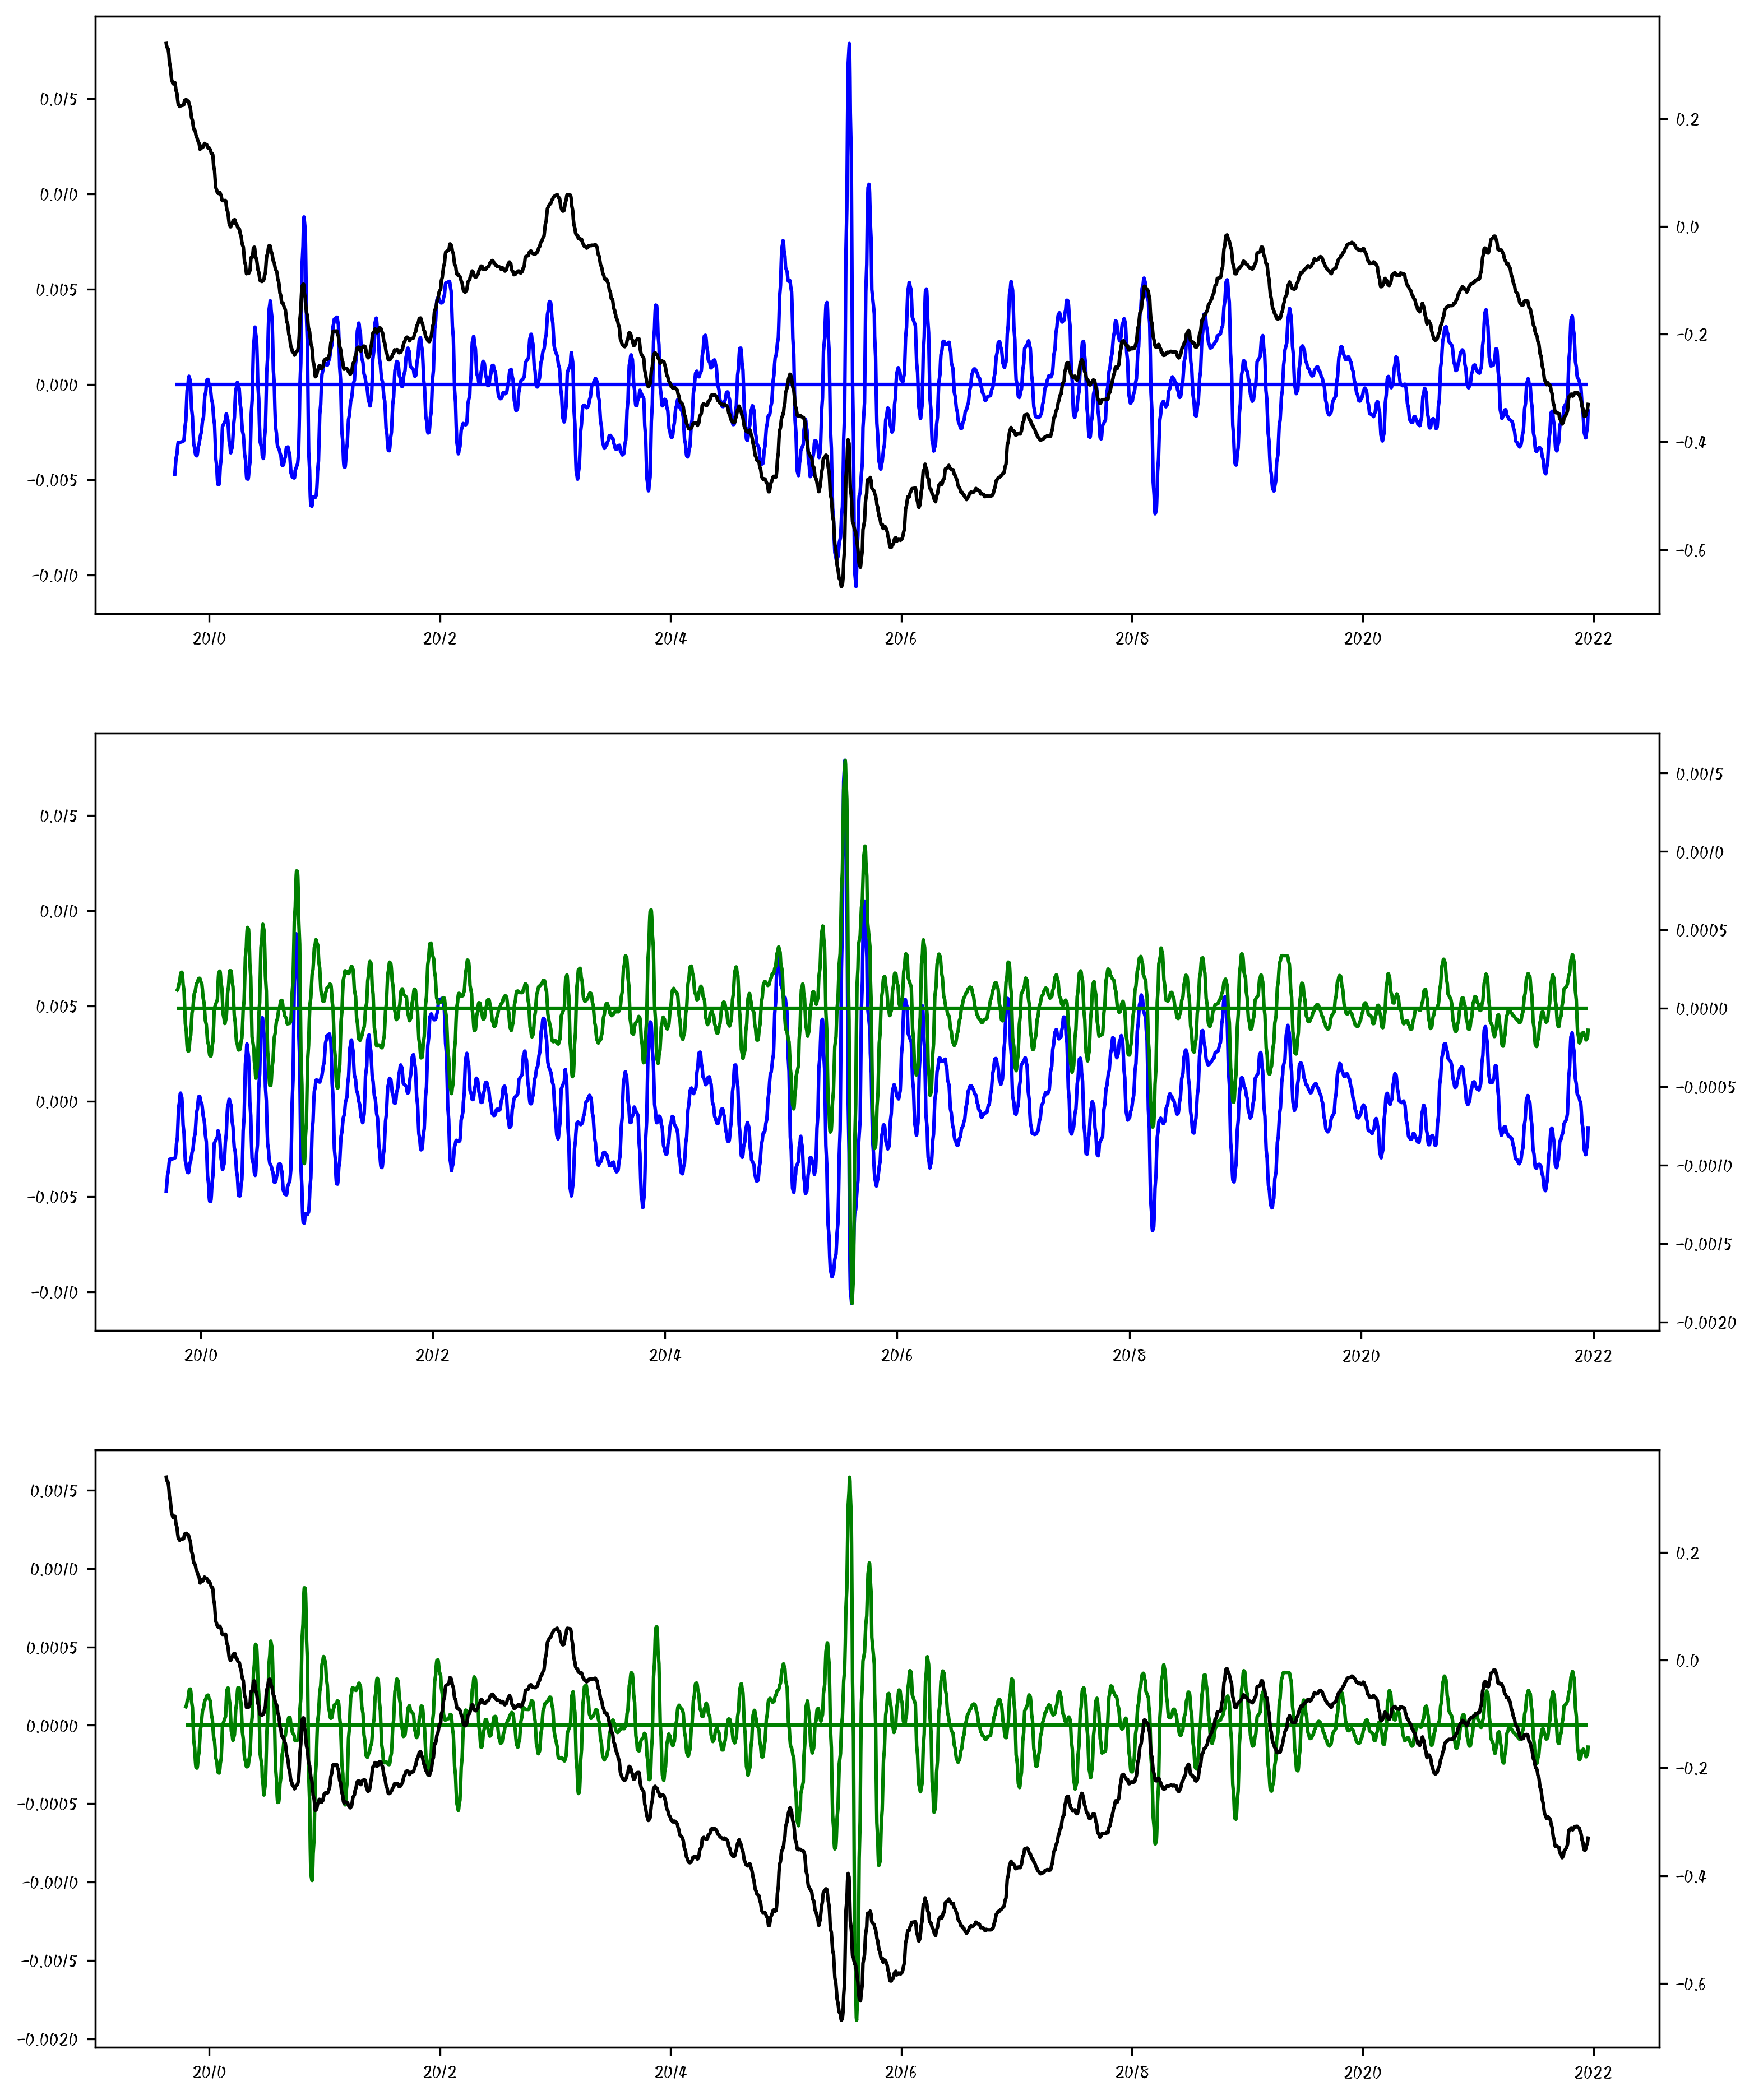

In [11]:
_, axes = plt.subplots(3, 1, figsize=(12, 16), dpi=300)

ax = axes[0]
ax.plot(derivative1, color='blue')
ax.hlines(0, xmin=derivative1.index[0], xmax=derivative1.index[-1], color='blue')
ax = ax.twinx()
ax.plot(rwsma, color='black')

ax = axes[1]
ax.plot(derivative1, color='blue')
ax = ax.twinx()
ax.plot(derivative2, color='green')
ax.hlines(0, xmin=derivative2.index[0], xmax=derivative2.index[-1], color='green')

ax = axes[2]
ax.plot(derivative2, color='green')
ax.hlines(0, xmin=derivative2.index[0], xmax=derivative2.index[-1], color='green')
ax = ax.twinx()
ax.plot(rwsma, color='black')

现在，我们将一阶“导数”作为纵坐标，二阶“导数”作为横坐标，按照时间的顺序一次链接在这个二维平面上的一阶导数和二阶导数的点。

根据研报描述，显然第一到第四象限分别对应的是第一到第四个阶段。

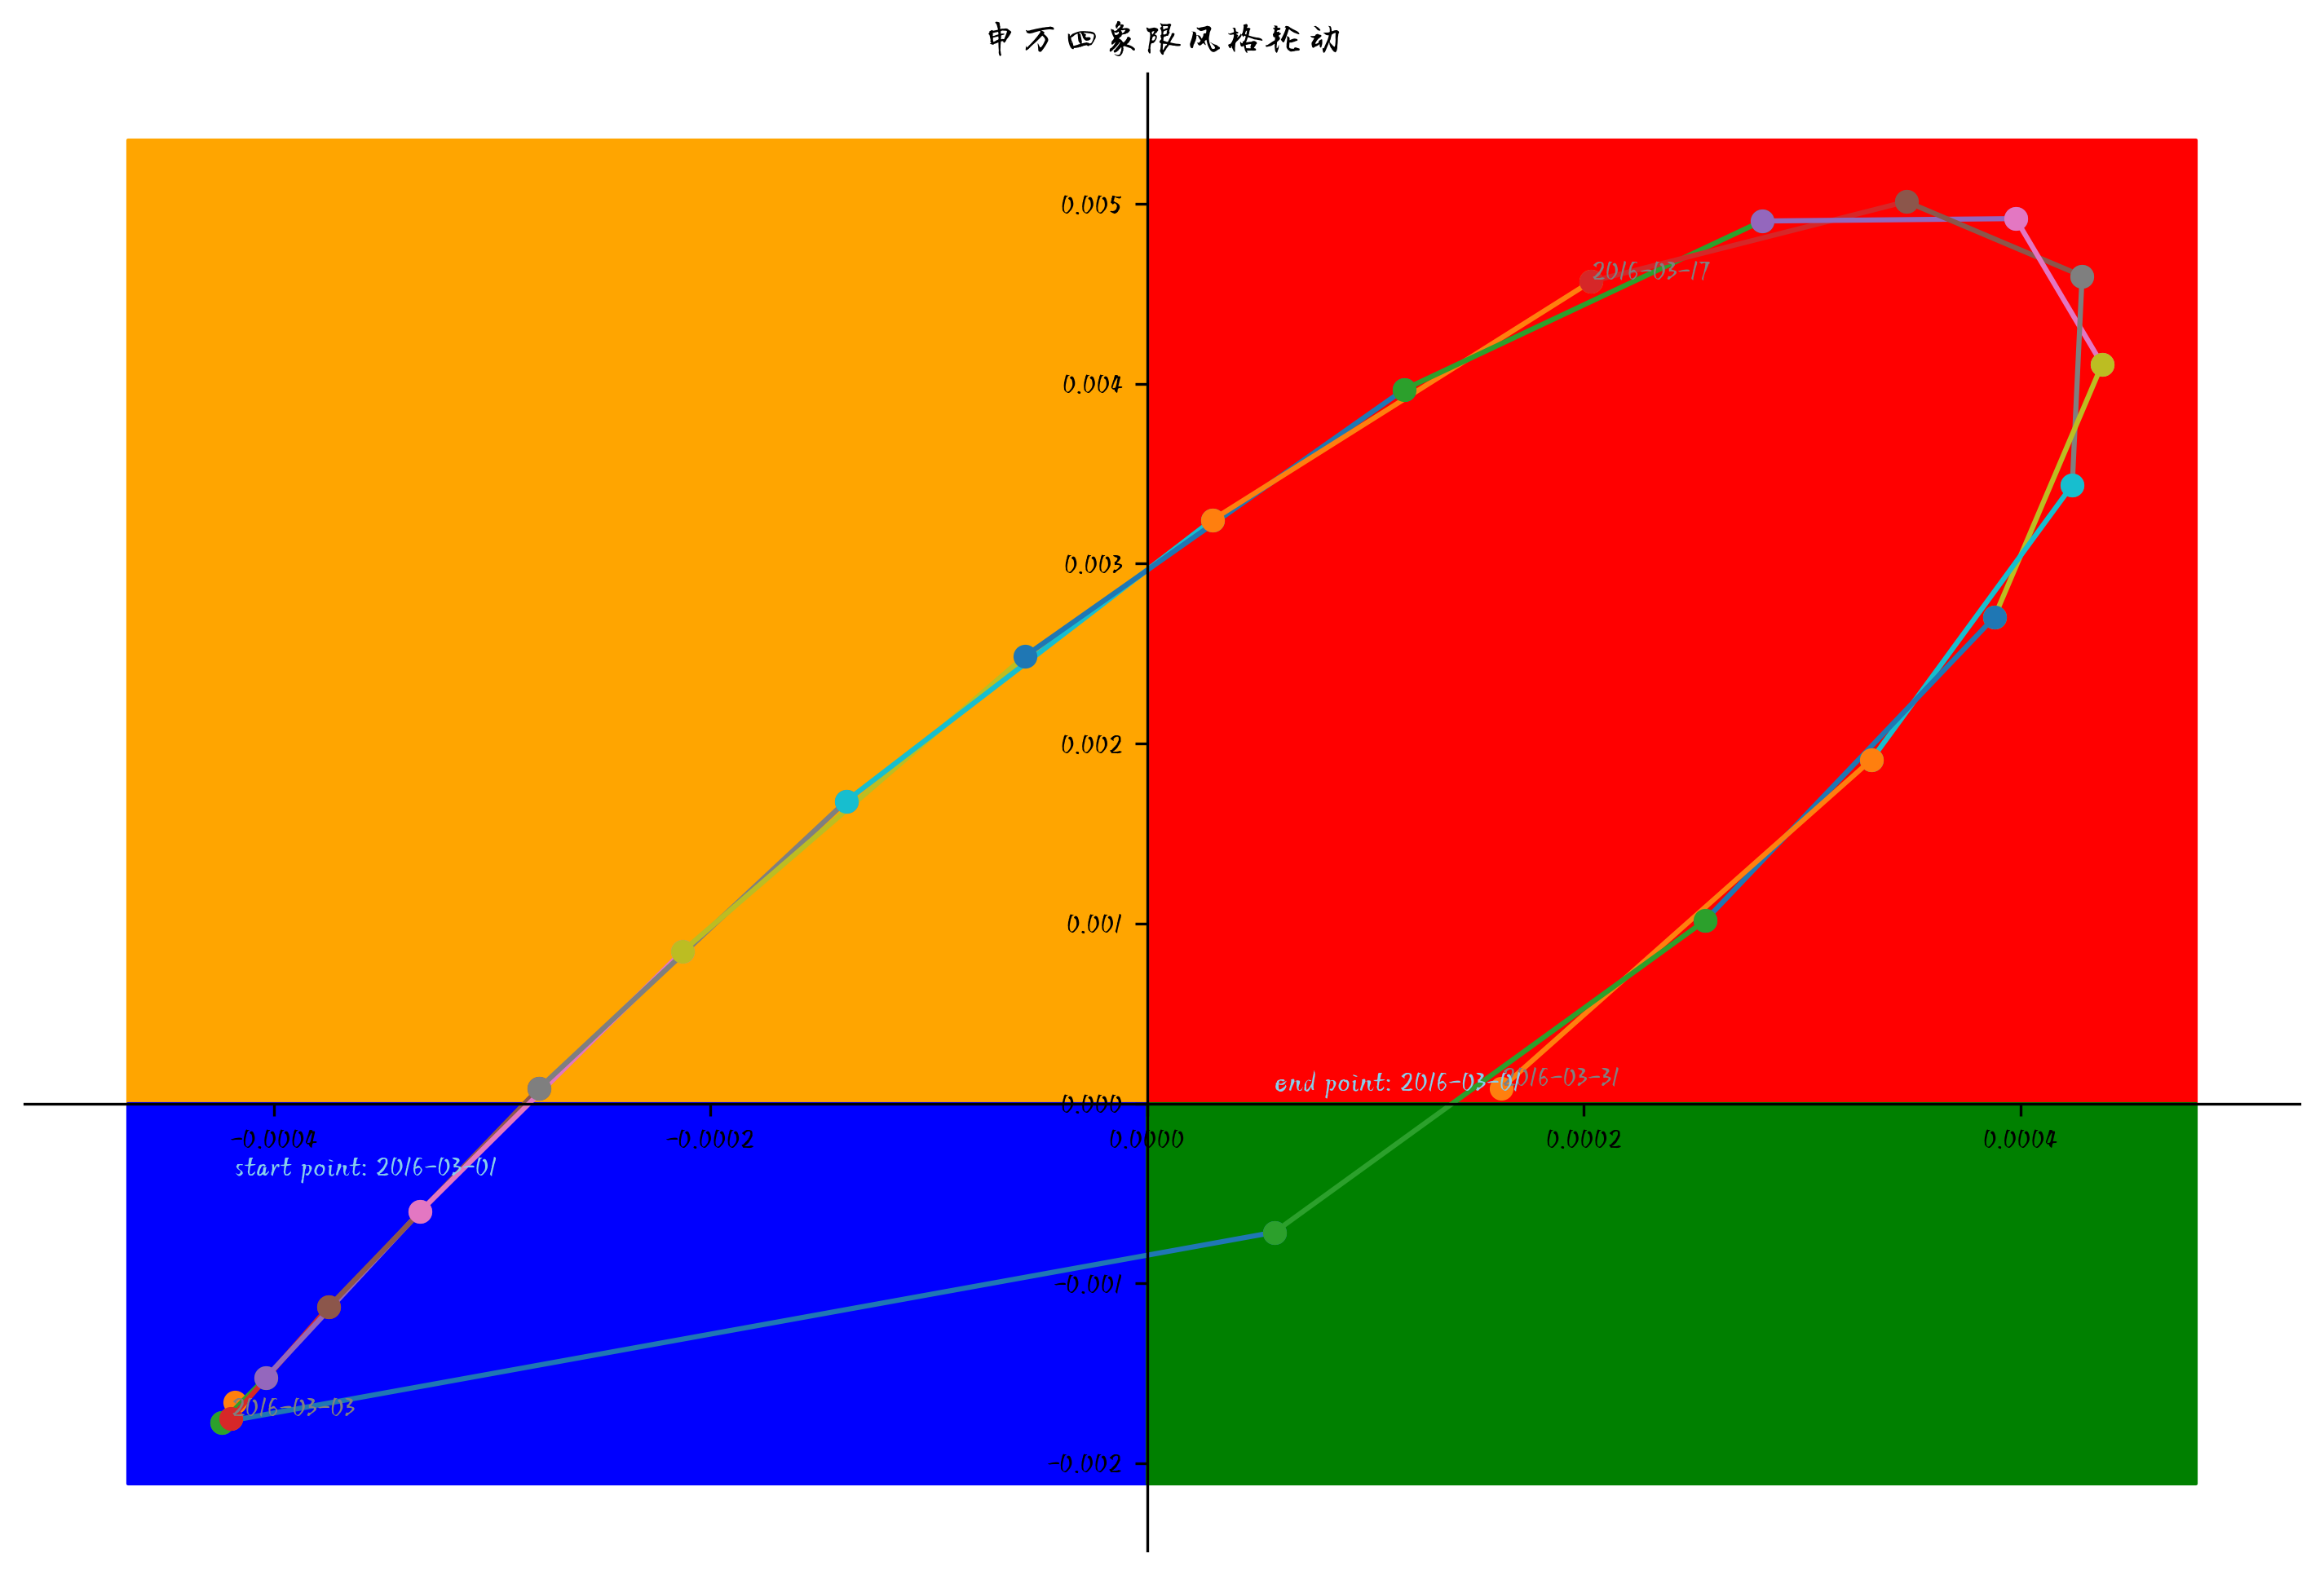

In [12]:
derivative1_draw = derivative1.loc["2016-03-01":"2016-04-01"]
derivative2_draw = derivative2.loc["2016-03-01":"2016-04-01"]
_, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
ax.set_title("申万四象限风格轮动")

common_date = derivative1_draw.index.intersection(derivative2_draw.index)
ax.text(x=derivative2_draw.iloc[0], y=derivative2_draw.iloc[0], 
        s=f'start point: {derivative2_draw.index[0].strftime(r"%Y-%m-%d")}', color="skyblue")
for i, date in enumerate(common_date[1:]):
    if i % 10 == 1:
        ax.text(x=derivative2_draw.loc[date], y=derivative1_draw.loc[date], s=date.strftime(r"%Y-%m-%d"), color="grey")
    last_date = common_date[i - 1]
    ax.plot(derivative2_draw.loc[[last_date, date]], derivative1_draw.loc[[last_date, date]], marker='o')
ax.plot(derivative2_draw.iloc[[-1, 1]], derivative1_draw.iloc[[-1, 1]], alpha=0.0, color='white')
ax.text(x=derivative2_draw.iloc[-1], y=derivative2_draw.iloc[-1], 
        s=f'end point: {derivative2_draw.index[0].strftime(r"%Y-%m-%d")}', color="skyblue")

# 象限填色
xp = np.linspace(0, ax.get_xlim()[1], 10)
yp = np.ones_like(xp) * ax.get_ylim()[1]
xn = np.linspace(ax.get_xlim()[0], 0, 10)
yn = np.ones_like(xn) * ax.get_ylim()[0]
zeroy = np.zeros_like(yp)
ax.fill_between(xp, yp, zeroy, color='red')
ax.fill_between(xn, zeroy, yp, color='orange')
ax.fill_between(xn, yn, zeroy, color='blue')
ax.fill_between(xp, yn, zeroy, color='green')

# 移动原点
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("data", 0))

从上述结果来看，整体的理论模型还是基本成立的，即行业相对强弱指数是不断的在重复一个从第一象限到第四象限的循环。